In [310]:
# TODO

# OK Make CSV separations for each edition
# NAH Look at any EXTRA CLEANING that can be done (eg. if definition is mostly noise, for_later)

# OK generate basic info CSV & give to Ava
# OK send to Ava, mention 40->20
# OK mention where i'm putting the PNGs

# OK Generate complex header & refs data for each edition, two-by-two and save as CSV
# OK quick sumcheck of all refs for each edition, investigate why 7&8 have less and where anatomy is in that one
# OK reply to Sarah

# OK longest word in each edition & definition (a bit manual) 
# OK word with most references to other topics in each edition & definition (& what that field is)

# FOR 5 AVA TOPICS:
# how many mentions of that topic in each edition
# OK some list of words with mentions of it & their definitions
# show the evolution of these words' definitions across editions?

# For TOPIC VISUALISATION:
# OK change colour to plain
# OK remove common outliers ("see next article"), etc
# OK remove "see"
# OK generate for all 8 editions
# associate to discoveries & evolutions of specific topics, ask data holder!
# click the word to see modern definition, contextual real-world events for why this topic is popular then

# For TOPIC PROPORTIONAL CHANGE:
# a (1) -- (2) -- (2) -- (3) mini-graph for the most popular topics, or a vine-graph indicating changes in all of top 20?

# or a bar chart-type thing, for topics with most changes or top 5 topics
# re-clean refs using the complete refs cleaning ft, and remove too-long refs
# check for shortest and longest ref?
# anatomy count across all editions, normalise by the count of total across editions (?)
# look at top 5 positions across time?
# "less important", "mostly mentioned in edition x"
# count overall all editions: most common topics, and visualise how they evolved
# bar chart progress rather than line chart
# make distances between values reflect year of publication

# FOR GROUPING TOPICS:
# NAH group top x topics into bigger topics eg. science, arts etc, and visualise horizontal bars of proportions in each edition
# NAH this is a lot of manual work tho, and the classification is fairly arbitrary as well

# WEBSITE:
# add to slider images of books to represent quantity of knowledge (each book is 100'000 words in that edition)
# publishing the final code in a clean github repository, add profiles of us on website
# images change as you change editions, or morphing of current/old images
# https://digital.nls.uk/encyclopaedia-britannica/archive/188936619
# small section with updates in supplements
# make sure we are using all of the CSVs

# PRESENTATION:
# slides responding to benjamin's questions in email
# what the encyclopaedia looked like, how topics are connected and how their popularity evolved across time
# comments on structure of encyclopaedia, less cross-refs, more long-form articles perhaps?
# comment on cleaning/what original text looks like
# restructuring of encyclopaedia in 7th and 8th, based on total refs and some words (5 topics) not being defined anymore

# SUBMISSION:
# guided video
# report

# OTHER:
# longest word, others in https://github.com/vaidap/library/issues/9?
# how definitions change across time for select words (longest def/shortest def)
# words with the largest change in definition length?

# #######################
# OK Ask Sarah about how editions are separated/duplicates.
# OK then, make this run for all editions in parts & save into CSVs
# Ask Sarah if we can see the real encyclopaedia?
# Ask Alexander about proportional word frequency, how to calc: prop of all frequency?

# OK generate data always on cleaned up versions of text

# OK look through CW2 cleanup & code: what could be ported over
# NAH for_later notes eg. \n clean

# DONE
# OK words/characters/volumes per edition
# OK run two_data & port re-format & visualisation from CW2
# OK save data in csv

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import csv
%matplotlib inline

In [2]:
# reading in index file

inventory = pd.read_csv("encyclopaediaBritannica-inventory.csv", header=None)
inventory.columns = ['file','volume']
# print(inventory)
print("\nNumber of text files: " + str(len(inventory)))


Number of text files: 195


## Selecting volumes for each edition

In [3]:
# ignore supplements & index volumes

first_ed = inventory[:3]
first_ed_reprint = inventory[3:7]
second_ed = inventory[6:16]
third_ed = inventory[16:34]
third_ed_reprint = inventory[34:52]
fourth_ed = inventory[56:96]
fifth_ed = inventory[96:116]
sixth_ed = inventory[116:136]
seventh_ed = inventory[152:172]
eighth_ed = inventory[173:194]

In [4]:
eighth_ed = inventory[173:194]
list(eighth_ed['volume']) # list() to print whole text

['Encyclopaedia Britannica - Eighth edition, Volume 1, Dissertations - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 2, A-Anatomy - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 3, Anatomy-Astronomy - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 4, Astronomy-BOM - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 5, Bombay-BUR - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 6, Burning glasses-Climate - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 7, CLI-DIA - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 8, Diamond-Entail - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 9, Entomology-FRA - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 10, France-GRA - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 11, GRA-HUM - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 12, Hume-JOM - EB.16',
 'Encyclopaedia Britannica - Eighth edition, Volume 13, Jona

In [5]:
# doesn't include reprints 
all_editions = [first_ed, second_ed, third_ed, fourth_ed, fifth_ed, sixth_ed, seventh_ed, eighth_ed]

In [6]:
# for testing
two_editions = [first_ed, second_ed]

## Basic statistics

In [7]:
# Reading in text files and generate volume, word and length counts

def basic_data(editions):
    
    data = []
    
    for ed in editions: 
        length = 0
        words = 0
        volumes = 0

        for index, row in ed.iterrows():
            print("Reading: " + row['file'])

            f = open('text/' + row['file'], 'r', encoding="utf8")
            content = f.read()
            content = clean_up(content)
            length += len(content)
            volumes += 1

            words += len(content.split())

            f.close()
            
        data.append([volumes, length, words])
        data_df=pd.DataFrame(data,columns=['volumes', 'length_chars','length_words'])
    return data_df

In [231]:
basic_df = basic_data(all_editions)
basic_df

Reading: 144133901.txt
Reading: 144133902.txt
Reading: 144133903.txt
Reading: 144850370.txt
Reading: 144850373.txt
Reading: 144850374.txt
Reading: 144850375.txt
Reading: 144850376.txt
Reading: 144850377.txt
Reading: 144850378.txt
Reading: 144850379.txt
Reading: 190273289.txt
Reading: 190273290.txt
Reading: 190273291.txt
Reading: 149977338.txt
Reading: 149977873.txt
Reading: 149978642.txt
Reading: 149979156.txt
Reading: 149979622.txt
Reading: 149981189.txt
Reading: 149981670.txt
Reading: 149982181.txt
Reading: 149982692.txt
Reading: 149983206.txt
Reading: 190273372.txt
Reading: 191253798.txt
Reading: 192200061.txt
Reading: 191253799.txt
Reading: 191319917.txt
Reading: 191253800.txt
Reading: 191253817.txt
Reading: 191253818.txt
Reading: 191253819.txt
Reading: 192545783.txt
Reading: 192545784.txt
Reading: 191809865.txt
Reading: 191809866.txt
Reading: 191253825.txt
Reading: 191253826.txt
Reading: 191320556.txt
Reading: 191320557.txt
Reading: 192547776.txt
Reading: 192547777.txt
Reading: 19

,volumes,length_chars,length_words
0,3,14191040,2567260
1,10,56733498,10172846
2,18,96884019,17414509
3,40,103931985,18672098
4,20,103686840,18617826
5,20,103513075,18597305
6,20,119701529,21056156
7,21,131624089,22878318


In [232]:
basic_df.to_csv('csv/basic_data.csv')

In [234]:
basic_reimport = pd.read_csv('csv/basic_data.csv')
print(basic_reimport) # edition 4 is actually 20 volumes because text files separate it into part 1 & 2

   Unnamed: 0  volumes  length_chars  length_words
0           0        3      14191040       2567260
1           1       10      56733498      10172846
2           2       18      96884019      17414509
3           3       40     103931985      18672098
4           4       20     103686840      18617826
5           5       20     103513075      18597305
6           6       20     119701529      21056156
7           7       21     131624089      22878318


## Most referenced topics

### Helper functions

#### For cleanup

In [57]:
def replace_by(s, a, b):
    """ perform a regex replacement, prints number of occurrences found and returns a string.
    s: string to make changes in
    a: string to remove 
    b: string to add
    returns: a string"""
    
    # print("Replacing \"" + a + "\" by \"" + b + "\", found " + str(len(re.findall(a, s))) + "...")
    new = re.sub(a, b, s)
    
    return new

In [58]:
# Using regex cleanup ideas from: https://sites.temple.edu/tudsc/2014/08/12/text-scrubbing-hacks-cleaning-your-ocred-text/

# Further resources: https://programminghistorian.org/en/lessons/cleaning-ocrd-text-with-regular-expressions
# https://datascience.stackexchange.com/questions/20536/how-to-improve-ocr-scanning-results

def clean_up(s):
    """ Does a minimal cleanup of a string of text
    returns: a string
    """
    # print("Initial length: " + str(len(s)))
    s2 = replace_by(s, 'tbe', 'the')
    s3 = replace_by(s2, 'tiie', 'the')
    s4 = replace_by(s3, 'liis', 'his')
    s5 = replace_by(s4, 'bis', 'his')
    s6 = replace_by(s5, '■', '')
    s7 = replace_by(s6, 'ib','in') # was noticed by Ava in .txt files
    s8 = replace_by(s7, '¬','')
    s9 = replace_by(s8, '.(\.\.+)', '') # multiple periods; what about ellipsis though?
    # print("Clean up done!")
    return s9 # CAREFUL to always pass the right one to next, and return

In [59]:
# This uses the list of header/definition/refs dataframes for each edition
# Check that this doesn't just do a reference replace, actually changes editions that are passed to it

def clean_up_definitions(editions):
    editions_cleaned = []
    for ed in editions:
        # realistically, a definition can't be shorter than 5 letters, even if it is simply a redirection of the form of "See x"
        ed = ed.loc[ed['def_length'] > 5]
        # remove headers with two letters as they are probably mostly noise
        ed = ed.loc[ed['header_length'] > 2]
        # remove headers longer than 40 characters, as these are likely to be noise
        ed = ed.loc[ed['header_length'] < 40]
        
        # We might also want to drop header duplicates, as each entry is only defined once
        # A good portion of these duplicates are probably noise (such as annotations in roman numerals)
        # We're not selecting the correct definition out of the duplicates here, just dropping them for the sake of simplicity
        ed.drop_duplicates(subset ="headers", keep = False, inplace = True)
        
        editions_cleaned.append(ed)
        
    return editions_cleaned

#### For extracting words and their definitions, and references ("See x")

In [60]:
# Uses RegEx to identify the definition of a word as being the content between the uppercase word and the next uppercase word

def find_definition(word, volume):
    start = re.search(word, volume).start()
    start_next = re.search(word, volume).end()
    
    second_word = re.search("[A-Z][A-Z]+", volume[start_next:])
    
    if second_word: # checking that second capitalised word exists (prevents NoneType exception)
        end = re.search("[A-Z][A-Z]+", volume[start_next:]).start()
        return volume[start_next+2:start_next+end] # +2 to ignore comma and space before a definition
    else:
        return ""

In [61]:
# Extracts entries (headers), their definitions, their respective lengths, and all references ("See x") from an edition

def extract_info(edition):
    
    headers = []
    definitions = []
    refs = [] # for counting up all instances of "See x" in volumes  
    
    for index, row in edition.iterrows():
        current_headers = []
        
        print("Reading: " + row['file'])
        f = open('text/' + row['file'], 'r', encoding="utf8")
        content = f.read()
        content = clean_up(content) # check cleanup does something
        # using https://stackoverflow.com/questions/9525993/get-consecutive-capitalized-words-using-regex
        # note: this ReGex is not entirely correct, as the first will select "MARTIAL" and "LAW"
        # "MARTIAL" will be cleaned out later due to having an empty definition, but "LAW" will have duplicates
        
        current_headers = re.findall('[A-Z][A-Z]+', content) # at least two uppercase letters following each other
        current_headers += re.findall('([A-Z][A-Z]+(?=\s[A-Z])(?:\s[A-Z][A-Z]+)+)', content) # two or more uppercase words
        refs += re.findall('See [^,\.]*', content) # matches "See x" until a comma or a period
        
        for word in current_headers:
            definitions.append(find_definition(word, content))
            
        headers = headers + current_headers
        
        f.close()

    data = pd.DataFrame(headers, columns =['headers'])
    data['definition'] = definitions
    data['header_length']  = data['headers'].str.len()
    data['def_length']  = data['definition'].str.len()
    return data, refs

In [62]:
# Generates a list of dataframes with words and their definitions for each edition

def words_and_definitions(editions):
    
    all_edition_data = []
    all_references = []
    
    for ed in editions:
        edition_data, references = extract_info(ed)
        all_edition_data.append(edition_data)
        all_references.append(references)
    return all_edition_data, all_references

### Generating headers, definitions and references for all editions and saving to CSV

In [14]:
# generate two editions by two editions, and save as CSV.
# function takes in a list of editions
seventh_eighth_data, seventh_eighth_refs = words_and_definitions([seventh_ed, eighth_ed])

Reading: 192984259.txt
Reading: 193057500.txt
Reading: 193108322.txt
Reading: 193696083.txt
Reading: 193322690.txt
Reading: 193819043.txt
Reading: 193322688.txt
Reading: 193696084.txt
Reading: 193469090.txt
Reading: 193638940.txt
Reading: 192693199.txt
Reading: 193108323.txt
Reading: 193322689.txt
Reading: 193819044.txt
Reading: 194474782.txt
Reading: 193469091.txt
Reading: 193469092.txt
Reading: 193057501.txt
Reading: 193913444.txt
Reading: 193819045.txt
Reading: 192984260.txt
Reading: 193322698.txt
Reading: 193696085.txt
Reading: 193696086.txt
Reading: 193108324.txt
Reading: 193109113.txt
Reading: 193109114.txt
Reading: 193108325.txt
Reading: 193322700.txt
Reading: 193109115.txt
Reading: 193469392.txt
Reading: 193696087.txt
Reading: 193916150.txt
Reading: 193696088.txt
Reading: 193592632.txt
Reading: 193322699.txt
Reading: 193819046.txt
Reading: 193108326.txt
Reading: 193322701.txt
Reading: 193469393.txt
Reading: 193819047.txt


In [15]:
seventh_eighth_cleaned = clean_up_definitions(seventh_eighth_data)
seventh_eighth_cleaned[0]

,headers,definition,header_length,def_length
55,AAHUS,"a little town of Germany, in the circle of\nWe...",5,210
56,AALBORG,one of the four sees (stiffs) into which\nthe ...,7,2275
58,AALEN,"a bailiwick in the circle of Jaxt, in the king...",5,773
59,AALSMEER,"a town in the arrondissement of Am\nsterdam, i...",8,205
60,AALTEN,"a town in the arrondissement of Zutphen,\nand ...",6,119
...,...,...,...,...
123231,PLATE CCCCXCV,Fin. 17.\n,13,9
123232,PLATE CCCCXCVH,4\nn „ - .\nI .\nh\n———\n©,14,21
123233,OTMISIEM IPAIM\nJPJLATE,cccxcix.\nSf Bloomsbrn^\n,22,23
123234,ZOOPHYTES\nPLATE,)11.\nAsatrLs hunbricoicUis.\nTetjurhynckus Un...,15,216


In [16]:
seventh_eighth_cleaned[0].to_csv('csv/seventh_ed_data.csv')
seventh_eighth_cleaned[1].to_csv('csv/eighth_ed_data.csv')

In [63]:
def generate_ref_counts(refs):
    
    all_ref_counts = []
    
    for ref in refs:
        # Converting unique counts to a DataFrame for easy visualisation
        ref_df = pd.DataFrame(ref)
        ref_counts = ref_df[0].value_counts()
        ref_counts = pd.DataFrame(ref_counts)
        ref_counts['references'] = ref_counts.index
        ref_counts.columns = ['count', 'references']
#         ref_counts = ref_counts.reset_index(True)

        # cleaning ref counts (removing non-topics such as "See the next article")
        ref_counts = ref_counts.loc[ref_counts['references'] != "See the next article"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See there"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See thefe articles"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See these articles"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See Vol"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See p"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See fig"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See that article"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See the preceding article"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See Supplement"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See SUPPLEMENT"]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("Plate")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("plate")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("Index")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("In\ndex")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("index")]
        
        # Change formatting to not have "See" in topic name
        ref_counts['references'] = ref_counts['references'].str.replace(r'See ', '')
        
        all_ref_counts.append(ref_counts)
    
        
    
    return all_ref_counts

In [24]:
seventh_eighth_refs_counts = generate_ref_counts(seventh_eighth_refs)
seventh_eighth_refs_counts[0]

,count,references
See Ornithology,43,Ornithology
See Mammalia,35,Mammalia
See Music,31,Music
See Metaphysics,27,Metaphysics
See Anatomy,26,Anatomy
...,...,...
See Chemist^\nZINZENDORF,1,Chemist^\nZINZENDORF
See the article Arabia,1,the article Arabia
See Hales’\nChronology,1,Hales’\nChronology
See the I ransia\ntion of Bayle’s Dictionary,1,the I ransia\ntion of Bayle’s Dictionary


In [25]:
seventh_eighth_refs_counts[0].to_csv('csv/seventh_ed_refs.csv')
seventh_eighth_refs_counts[1].to_csv('csv/eighth_ed_refs.csv')

In [57]:
seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references == "the article Optics"]

,Unnamed: 0,count,references


In [55]:
seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references == "Optics"]

,Unnamed: 0,count,references
17,See Optics,23,Optics


In [54]:
seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references == "Optics", "count"] = 11 + 12

In [56]:
seventh_eighth_refs_counts[0] = seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references != "the article Optics"]

In [62]:
seventh_eighth_refs_counts[0] = seventh_eighth_refs_counts[0].sort_values(by=['count'], ascending=False)

In [58]:
seventh_eighth_refs_counts[0].to_csv('csv/seventh_ed_refs_fixed.csv')

In [39]:
seventh_eighth_refs_counts[0] = pd.read_csv('csv/seventh_ed_refs.csv')

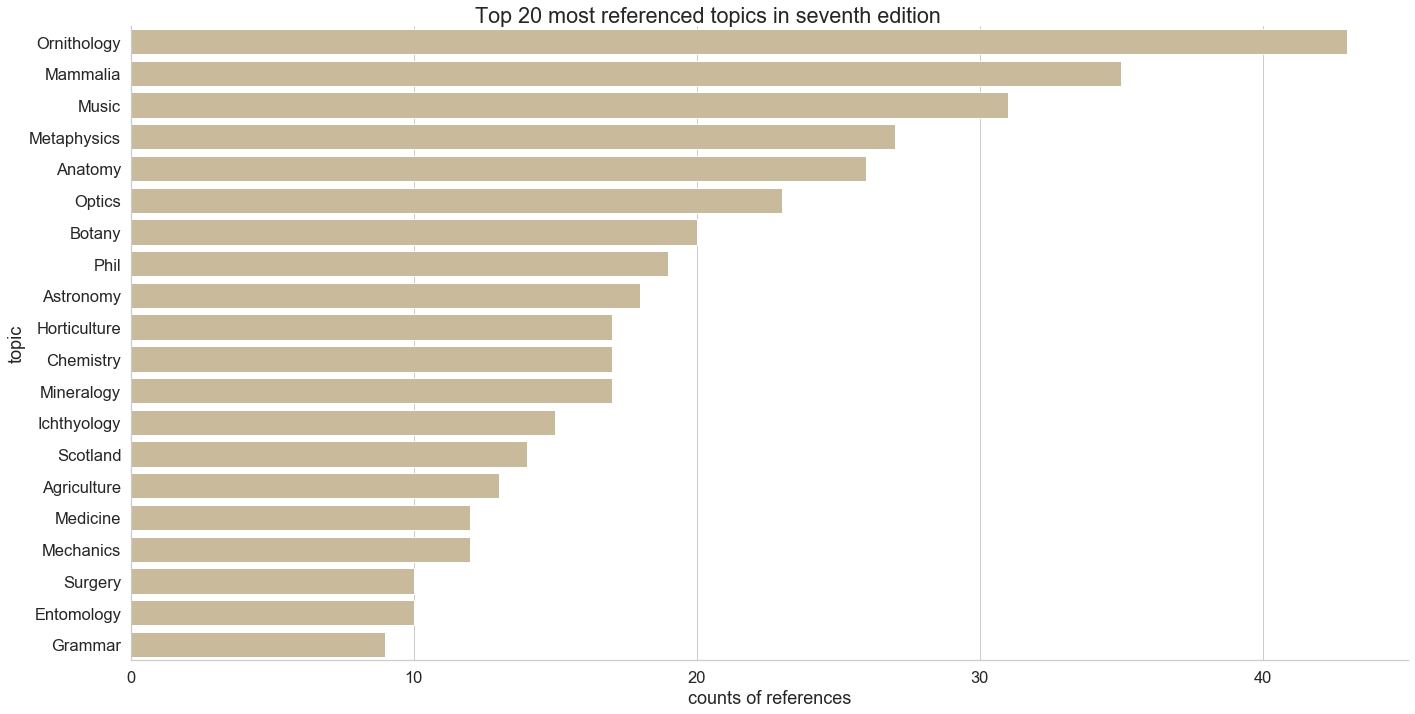

In [64]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
ax = sns.catplot(x='count', y='references', data=seventh_eighth_refs_counts[0].head(20), kind='bar', height=10, aspect=2, color="#cfbd93")
ax.fig.suptitle("Top 20 most referenced topics in seventh edition", y=1)
ax.set_axis_labels('counts of references', 'topic')

### Overall number of references in each edition

In [8]:
references = []
references.append(pd.read_csv('csv/first_ed_refs.csv'))
references.append(pd.read_csv('csv/second_ed_refs.csv'))
references.append(pd.read_csv('csv/third_ed_refs.csv'))
references.append(pd.read_csv('csv/fourth_ed_refs.csv'))
references.append(pd.read_csv('csv/fifth_ed_refs.csv'))
references.append(pd.read_csv('csv/sixth_ed_refs.csv'))
references.append(pd.read_csv('csv/seventh_ed_refs.csv'))
references.append(pd.read_csv('csv/eighth_ed_refs.csv'))
len(references)

8

In [9]:
sum_refs = []
for refs in references:
    sum_refs.append(refs['count'].sum())
sum_refs

[4909, 7020, 9363, 8811, 8687, 8895, 3489, 6032]

In [80]:
# dip might be due to different formatting of referencing?
# more longform articles rather than entries with references to main topic?

Text(0, 0.5, 'counts of references')

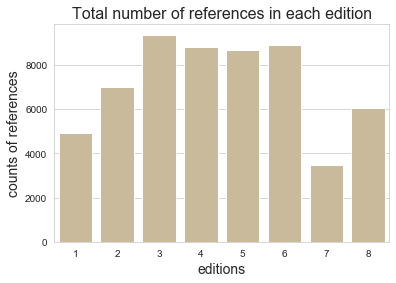

In [55]:
ed_count = list(range(1, 9))
sns.set_style("whitegrid")
ax = sns.barplot(x= ed_count, y=sum_refs, color="#cfbd93")
ax.set_title('Total number of references in each edition', fontsize=16)
ax.set_xlabel('editions', fontsize=14)
ax.set_ylabel('counts of references', fontsize=14)

### One of the longest words in each edition

In [7]:
headers = []
headers.append(pd.read_csv('csv/first_ed_data.csv'))
headers.append(pd.read_csv('csv/second_ed_data.csv'))
headers.append(pd.read_csv('csv/third_ed_data.csv'))
headers.append(pd.read_csv('csv/fourth_ed_data.csv'))
headers.append(pd.read_csv('csv/fifth_ed_data.csv'))
headers.append(pd.read_csv('csv/sixth_ed_data.csv'))
headers.append(pd.read_csv('csv/seventh_ed_data.csv'))
headers.append(pd.read_csv('csv/eighth_ed_data.csv'))
len(headers)

8

In [41]:
# this is mostly manual inspection, as the longest headers are often errors
# selected not necessarily the longest valid word, but one of the longest ones that has a more readable/identifiable description

In [84]:
headers[0].loc[headers[0]['header_length'] > 30]

,Unnamed: 0,headers,definition,header_length,def_length
4419,7779,EXTENSOR MINIMI DIGITI PROPRIUS,This is a kind of collateral or auxiliary mufc...,31,383
4483,7861,THE PARTS OF GENERATION IN\nMALES,The fpermatic arteries go out moft commonly fr...,32,4066
15803,29601,ENCYCLOPAEDIA BRITANNICA\nVOLUME,"he T H I R D,\nEncyclopaedia Britannica;\nO R,...",31,47


In [85]:
re.sub("\n", " ", headers[0].iloc[4419].definition) # remove \n for simpler formatting

'This is a kind of collateral or auxiliary mufcle of the extenfor communis, of which it appears almoit al ways to be more or lefs a portion. It is fixed along the fuperior external half of the ul na, from whence its long fmall tendon runs down in company with the fourth tendon of the extenfor commu nis, all the way to the little finger, where it joins it, and is infer ted with it. '

### Words that reference a specific topic

In [13]:
# again, requires manual inspection of what definitions are not just references to the main article
# as well as having concise and fairly clean defs

In [102]:
for i in range(0, len(headers)):
    print(list(headers[i].loc[headers[i]['headers'].str.match("ORTHOPNOEA")].definition))

['in medicine, a fpecies or degree of\nalthma, where there is fuch a difficulty of refpiration,\nthat the patient is obliged to fit or ftand upright, to be\n•able to breathe. See Medicine.\n']
['a fpecies or degree of.afthma,\nwhere there is fuch a difficulty of refpiration, that the\npatient is obliged to fit or ftand upright, in order to\nbe able to breathe. See Medicine, n° 396.\n']
['a fpecies or degree of aflhma,\nwhere there is fuch a difficulty of refpiration that the\npatient is obliged to lit or Hand upright in older to\nbe able to breathe. See Medicine, n° 291.\n']
["a fpecies or degree of afthma\nvyhere.there.is fuch a difticulty of refpiration that the pa*\ntient is obliged to fit or Hand uptight in order to be\nable to breathe. See Medicine Index. '\n"]
['a fpecies or degree of afthma,\nwhere there is fuch a difficulty of refpiration that the\npatient is obliged to fit or Hand upright in order to be\nable to breathe. See Medicine Index,\n']
['a species or degree of asthma,

In [38]:
list(headers[5].loc[headers[5]['headers'].str.contains("ENTABLATURE")].definition)

['or Entablement, in Archi\ntecture, is that part of an order of a column which is\nover the capital, and comprehends the architrave, frize,\nand corniche. See Architecture, chap. i.\n']

In [99]:
headers[0].loc[(headers[0]['definition'].str.contains("See Medicine")) & (headers[0]['def_length'] > 35)].iloc[50:100]

,Unnamed: 0,headers,definition,header_length,def_length
10309,19062,CHIN COUGH,"a convulfive kind of cough, which\nchildren ar...",10,81
10524,19345,MADNESS,"a moft dreadful kind of delirium, without\na f...",7,65
10774,20098,MELANCHOLY,"in medicine, a kind of delirium, at\ntended wi...",10,102
10815,20150,MENSES,"Flours,Courses, Catamenia, in medicine,\nthe m...",6,139
10931,20781,MILIARY,"in general, fomething refembling millet-\nfeed...",7,84
11431,22408,NIGHT,that part of the natural day during which the\...,5,795
11627,22657,OEDEMA,in medicine and furgery. See Medicine\n' and S...,6,53
11721,22778,OPHTHALMIA,"in medicine, an inflammation of the\nmembranes...",10,170
11822,23207,ORTHOPNOEA,"in medicine, a fpecies or degree of\nalthma, w...",10,184
12014,23460,PARAPHIMOSIS,"in medicine, a diforder in the penis,\nwherein...",12,223


In [101]:
re.sub("\n", " ", headers[0].iloc[11822].definition)

'in medicine, a fpecies or degree of althma, where there is fuch a difficulty of refpiration, that the patient is obliged to fit or ftand upright, to be •able to breathe. See Medicine. '

### Words with most references to other topics

In [149]:
headers_with_refs = headers.copy()

In [150]:
# find all references of the form of "See x" in definitions 

for ed in range(0, len(headers_with_refs)):
    refs_in_desc = []
    for index, row in headers_with_refs[ed].iterrows():   
        refs_in_desc.append(len(re.findall('See [^,\.]*', row['definition']))) # matches "See x" until a comma or a period
    headers_with_refs[ed] = headers_with_refs[ed].assign(refs_in_desc=refs_in_desc)

In [152]:
headers_with_refs[0].describe()

,Unnamed: 0,header_length,def_length,refs_in_desc
count,16012.000000,16012.000000,16012.000000,16012.000000
mean,14743.465838,7.662690,295.386835,0.259805
std,9001.624128,2.713464,821.197692,0.498402
min,34.000000,3.000000,6.000000,0.000000
25%,7203.750000,6.000000,75.000000,0.000000
50%,13415.500000,7.000000,137.000000,0.000000
75%,23454.250000,9.000000,260.000000,0.000000
max,29875.000000,32.000000,37810.000000,6.000000


In [238]:
# Again, the checking is manual, as some of the headers/definitions are noise that is picked up 
# (eg. a "CCCCLXXXVIL"-type header)

In [300]:
def most_refs_word(ed, word, adjuster):
    # adjuster is for easily looking at words with less references, if more referenced words are noise
    most_refs = np.max(headers_with_refs[ed]['refs_in_desc']) - adjuster 
    longest = headers_with_refs[ed].loc[headers_with_refs[ed]['refs_in_desc'] == (most_refs)]
    print("Number of words with most refs: " + str(len(longest)) + ", with number of refs: "\
          + str(most_refs) + "\n")
    print(list(longest.headers)[word])
    print(re.sub("\n", " ", list(longest.definition)[word]))

In [308]:
most_refs_word(7, 0, 1)

Number of words with most refs: 2, with number of refs: 5

IONIC
rder. See Architecture. Ionic Sect, The, was the oldest of the ancient schools of philosophy. It originated in Asia Minor, under Thales of Miletus, about 600 b.c. Its most famous leaders after Thales were Anaximander of Miletus, Pherecydes of Syra, Anaximenes of Miletus, Heraclitus of Ephesus, Anaxagoras and Hermotimus of Clazomenae, and Diogenes of Apollonia. From Asia Minor the spirit of the Ionic philosophy passed into Greece, at first with Anaxagoras, and afterwards with Archelaus, the master of Socrates. Thus Athens, taught from Ionia, became in turn the headquarters of philosophy, and the parent of the most celebrated Greek schools. The interval between Thales and Archelaus embraced a period of about 150 years. The philosophers of the Ionic school directed their attention principally to physics and morals. A few only of their principles and beliefs can now be ascer tained from the fragments which have come down to u

In [131]:
list(headers_with_refs[0].loc[headers_with_refs[0]['refs_in_desc'] == 6].headers)

['AXIS', 'CALCULUS']

In [133]:
list(headers_with_refs[0].loc[headers_with_refs[0]['refs_in_desc'] == 6].definition)

[]

In [147]:
re.sub("\n", " ", list(headers_with_refs[1].loc[headers_with_refs[1]['refs_in_desc'] == 7].definition)[0])

"in geometry, a plane figure comprehended by a Angle curve line, called its circumference, to which right lines drawn from a point in the middle, called the centre, are equal to each other. See Geo metry. Circles of the Sphere, are fuch as cut the mundane fphere, and have their periphery either on its move- able fiirface, or in another immoveable, conterminous, and equidifiant furface. See Sphere. Hence arife two kinds of circles, moveable and immoveable. The firft, thofe whofe peripheries are in the moveable fur- face, and which therefore revolve with its diurnal mo tion ; as, the meridians, &c. The latter having Circles their periphery in the immoveable furface, do not re- c;rcoJlcel. volve ; as the ecliptic, equator, and its parallels, &c. ‘^nes. See Geography. '   Circles of Altitude, otherwife called almucantars, are circles parallel to the horizon, having their com mon pole in the zenith, and ftill diminilhing as they approach the zenith. See Almucantar. Diurnal Circles, are immo

### Proportional topic popularity changes

In [14]:
sum_refs = []
for refs in references:
    sum_refs.append(refs['count'].sum())
sum_refs

[4909, 7020, 9363, 8811, 8687, 8895, 3489, 6032]

In [27]:
references[6]

,Unnamed: 0,count,references
0,See Ornithology,43,Ornithology
1,See Mammalia,35,Mammalia
2,See Music,31,Music
3,See Metaphysics,27,Metaphysics
4,See Anatomy,26,Anatomy
...,...,...,...
2652,See Chemist^\nZINZENDORF,1,Chemist^\nZINZENDORF
2653,See the article Arabia,1,the article Arabia
2654,See Hales’\nChronology,1,Hales’\nChronology
2655,See the I ransia\ntion of Bayle’s Dictionary,1,the I ransia\ntion of Bayle’s Dictionary


In [92]:
def change_in_topic_vis(topic, editions_ref_counts):
    
    counts = []
    sum_refs = []
    
    for i in range(0, len(editions_ref_counts)):
        try: 
            counts.append(int(editions_ref_counts[i].loc[editions_ref_counts[i].references == topic]['count']) / editions_ref_counts[i]['count'].sum())
        except: # handle case where a topic was never referenced in early editions
            counts.append(0) 
    # proportional popularity, by dividing count by total number of references in an edition
    ed_count = list(range(1, 9))
    sns.set_style("whitegrid")
    ax = sns.barplot(x= ed_count, y=counts, color="#cfbd93")
    ax.set_title('Popularity of ' + topic + ' across editions', fontsize=16)
    ax.set_xlabel('editions', fontsize=14)
    ax.set_ylabel('proportion of references', fontsize=14)

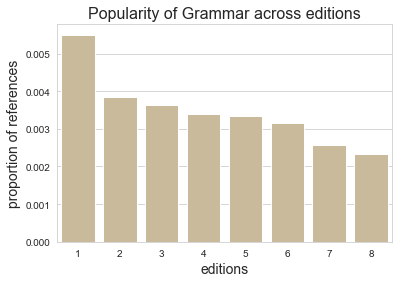

In [103]:
change_in_topic_vis("Grammar", references) # some interesting ones, eg. music/poetry state this doesn't mean less popular.
# could mean it was made into a separate topic, longform-articles


In [39]:
def show_change_in_topic(topic, editions_ref_counts):

    counts = change_in_topic(topic, editions_ref_counts)
    
    data = pd.DataFrame({"editions" : [""Edition 1", "Edition 2", "Edition 3""],
                     "reference_count" : counts})

    plt.plot("editions", "reference_count", data=data)
    plt.show()

SyntaxError: invalid syntax (<ipython-input-39-5d9d1667aaa2>, line 5)

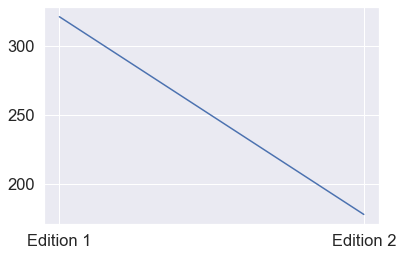

In [156]:
show_change_in_topic("See Anatomy", two_edition_ref_counts)

### Main topic analysis

In [169]:
len(two_data_cleaned[0].loc[two_data_cleaned[0].definition.str.contains("See Anatomy")])
# not same number, as other just checks ALL MENTIONS, not just in ref

262

### Total number of references for top 20 topics for all editions

In [105]:
references[0]

,Unnamed: 0,count,references
0,See Anatomy,321,Anatomy
1,See Law,151,Law
2,See Medicine,131,Medicine
3,See Chemistry,119,Chemistry
4,See Astronomy,112,Astronomy
...,...,...,...
2561,See Apamea,1,Apamea
2562,See next article,1,next article
2563,See Gem,1,Gem
2564,See Leu-\nCACANTHA,1,Leu-\nCACANTHA


In [106]:
total_refs = pd.DataFrame(columns=['ref', 'count'])
total_refs

,ref,count


In [112]:
total_refs = pd.DataFrame(columns=['ref', 'count'])
for index, row in references[0].iterrows():
    count = 0
    for ed in references:
        try: 
            count += int(ed.loc[ed.references == row.references]['count'])
        except: # handle case where a topic was never referenced in early editions
            pass
    total_refs = total_refs.append({'ref': row.references, 'count': count}, ignore_index=True)
        
print(total_refs)

                 ref count
0            Anatomy  1235
1                Law   497
2           Medicine   429
3          Chemistry   608
4          Astronomy   397
...              ...   ...
2561          Apamea     9
2562    next article     7
2563             Gem     5
2564  Leu-\nCACANTHA     1
2565       Sassafras     1

[2566 rows x 2 columns]


In [116]:
"Anatomydfsafsafsa" not in total_refs.values

True

In [10]:
total_refs = pd.DataFrame(columns=['ref', 'count'])

for i in range(0, len(references)):
    for index, row in references[i].iterrows():
        #only process a word in an edition if it was not processed by a previous edition
        if (row.references not in total_refs.values):          
            count = 0
            for ed in references[i:]:
                try: 
                    count += int(ed.loc[ed.references == row.references]['count'])
                except: # handle case where a topic was never referenced in early editions
                    pass
            total_refs = total_refs.append({'ref': row.references, 'count': count}, ignore_index=True)
            
print(total_refs)

                                    ref count
0                               Anatomy  1235
1                                   Law   497
2                              Medicine   429
3                             Chemistry   608
4                             Astronomy   397
...                                 ...   ...
22761       Hamilton’s edition\nof Reid     1
22762                            Quilon     1
22763  the\n(Euvres Completes de Volney     1
22764       the historical\npart of art     1
22765                            Police     1

[22766 rows x 2 columns]


In [13]:
# sort and also, check why original code didn't return the same size as original ref

In [14]:
total_refs = total_refs.sort_values(by=['count'], ascending=False)

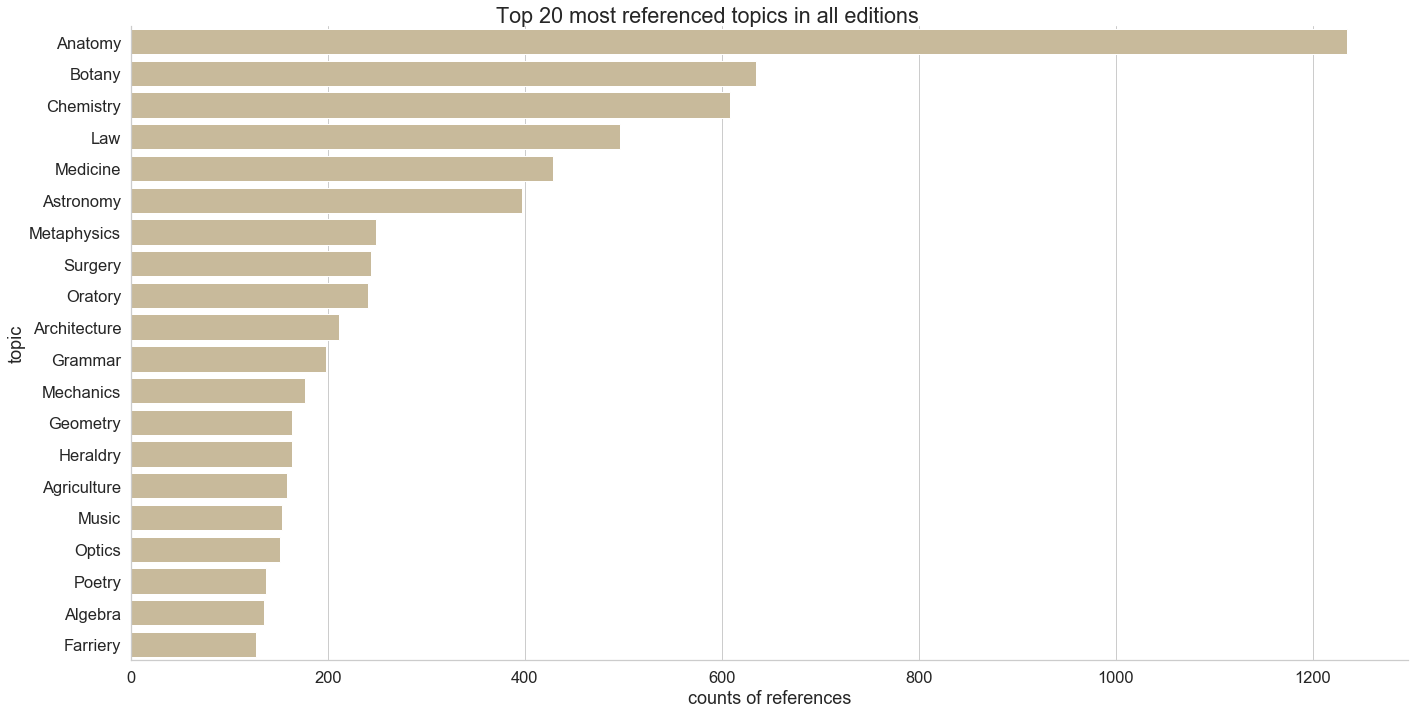

In [17]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
ax = sns.catplot(x='count', y='ref', data=total_refs.head(20), kind='bar', height=10, aspect=2, color="#cfbd93")
ax.fig.suptitle("Top 20 most referenced topics in all editions", y=1)
ax.set_axis_labels('counts of references', 'topic')